# Set up

Python librairies imports :

In [1]:
# File system management
import os
import pickle
import dill

from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

Define work location :

In [2]:
project_path = "/Users/victor/Documents/OPENCLASSROOMS/projet_7"

# Change directory
os.chdir(project_path)

Load data :

In [3]:
# Load data
data = pd.read_csv("data/processed/train_feature_engineering.csv", index_col=[0])
data_test = pd.read_csv("data/processed/test_feature_engineering.csv", index_col=[0])

# Functions

In [4]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [5]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [6]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

# MLFlow

Set up of MLFlow tracking.

In [7]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Create experiment
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

In [8]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

# Data preparation

In [9]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

## Missing values

In [10]:
# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))

Missing values = 37539165 (20.11%)


I fill the missing values with a simple imputer.

In [11]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)

## Split data

I split the data into training and testing sets.

In [12]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [13]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Balance data

In [14]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 226201, 1.0: 19804})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})
Ratio is 1:11


I will define a pipeline that first transforms the training dataset with SMOTE then fits the model.

In [15]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
# steps = [('over', over)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 113100, 1.0: 113100})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})


## Custom loss function

Rule : cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)

In [16]:
# Custom loss function based on business rule
def business_loss_func(y_true, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp + (10 * fn)) / len(y_true)
    return float(cost)

In [17]:
# # Custom loss function for xgboost
# def xgb_custom_loss_func(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     fnr = fn / (fn + tp)  # false negative rate
#     fpr = fp / (fp + tn)  # false positive rate
#     cost = float((10 * fnr) + fpr)
    
#     grad = np.repeat(2 * cost, len(y_pred))
#     hess = np.repeat(2, len(y_pred))

#     return grad, hess

In [18]:
# # Custom loss function for lightgbm
# def lgbm_custom_loss_func(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     fnr = fn / (fn + tp)  # false negative rate
#     fpr = fp / (fp + tn)  # false positive rate
#     cost = float((10 * fnr) + fpr)
    
#     grad = 2 * cost
#     hess = 2

#     return grad, hess

I create custom scorer with the business rule.

In [19]:
# Create business score
business_score = make_scorer(business_loss_func, greater_is_better=False)

# Classification

In [20]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict values 
    y_pred = model.predict(x_test)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Draw roc curve
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Display business loss func
    business_score = business_loss_func(y_test, y_pred)
    print("Business score =", business_score)

    return business_score, auc_score, clf_report

# DummyClassifier

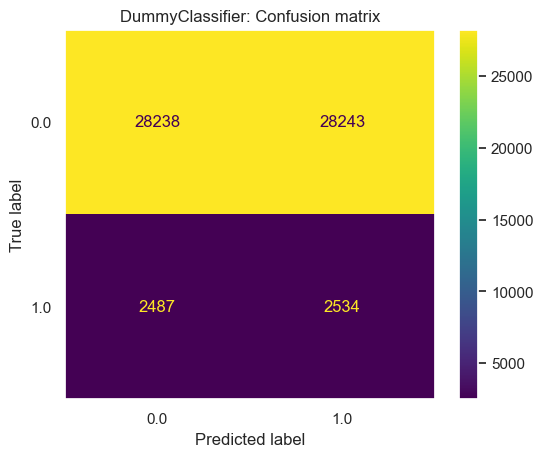

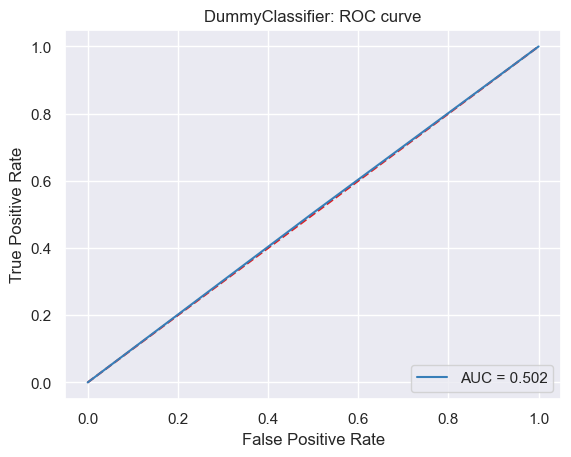

,precision,recall,f1-score,support
0.0,0.919056,0.499956,0.647616,56481.000000
1.0,0.082334,0.504680,0.141572,5021.000000
accuracy,0.500341,0.500341,0.500341,0.500341
macro avg,0.500695,0.502318,0.394594,61502.000000
weighted avg,0.850746,0.500341,0.606303,61502.000000


Business score = 0.8635979317745764


Setuptools is replacing distutils.


In [21]:
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Fit model
dc.fit(x_res, y_res)

# Compute results
dc_business_score, dc_auc, dc_report = compute_classification_results(dc, dc_name, x_test, y_test)

# Save logs
log_mlflow(dc, dc_name, auc_score=dc_auc, custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=dc_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

# LogisticRegression

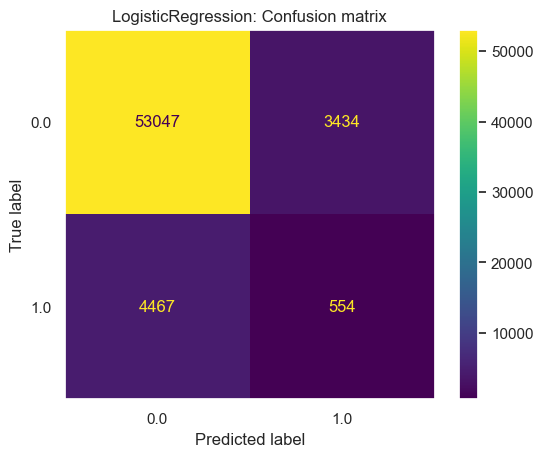

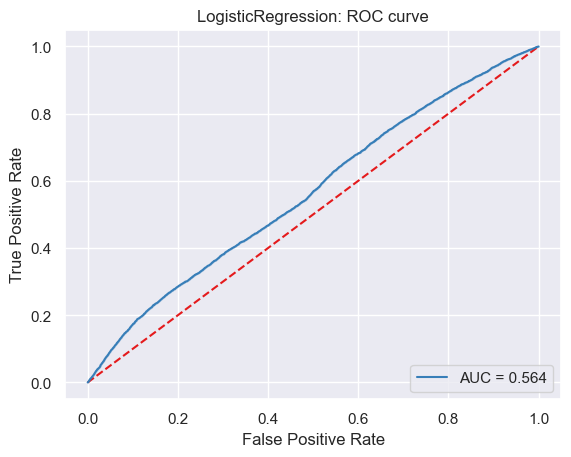

,precision,recall,f1-score,support
0.0,0.922332,0.939201,0.930690,56481.000000
1.0,0.138917,0.110337,0.122988,5021.000000
accuracy,0.871533,0.871533,0.871533,0.871533
macro avg,0.530624,0.524769,0.526839,61502.000000
weighted avg,0.858374,0.871533,0.864749,61502.000000


Business score = 0.7821534259048486
CPU times: user 1min 20s, sys: 656 ms, total: 1min 21s
Wall time: 37.7 s


In [22]:
%%time

# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_name = 'LogisticRegression'

# Train model
lr.fit(x_res, y_res)

# Compute results
lr_business_score, lr_auc, lr_report = compute_classification_results(lr, lr_name, x_test, y_test)

# Save logs
log_mlflow(lr, lr_name, auc_score=lr_auc, custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

# RandomForest

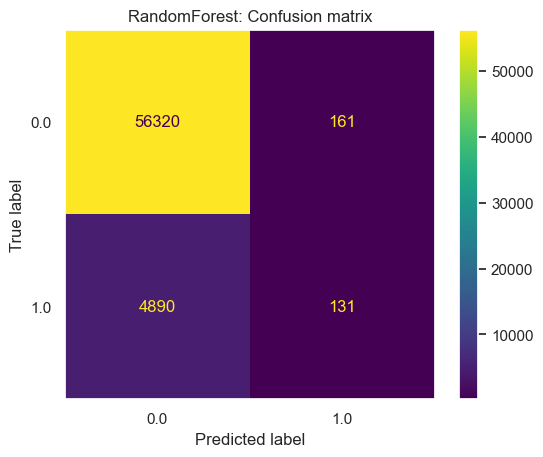

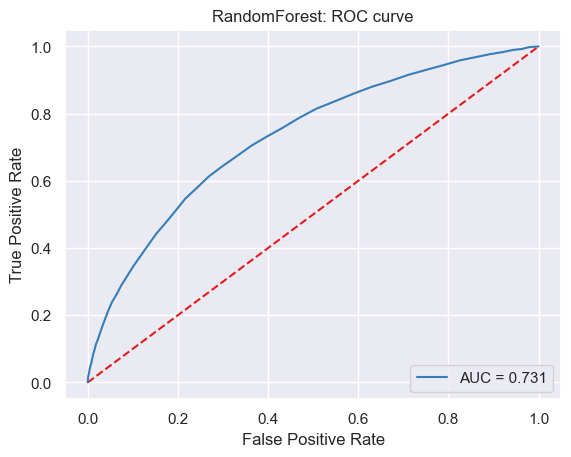

,precision,recall,f1-score,support
0.0,0.920111,0.997149,0.957083,56481.000000
1.0,0.448630,0.026090,0.049313,5021.000000
accuracy,0.917873,0.917873,0.917873,0.917873
macro avg,0.684371,0.511620,0.503198,61502.000000
weighted avg,0.881620,0.917873,0.882973,61502.000000


Business score = 0.7977138954830737
CPU times: user 2min 21s, sys: 1.24 s, total: 2min 22s
Wall time: 2min 24s


In [23]:
%%time

# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_name = 'RandomForest'

# Train model
rf.fit(x_res, y_res)

# Compute results
rf_business_score, rf_auc, rf_report = compute_classification_results(rf, rf_name, x_test, y_test)

# Save logs
rf_params = rf.get_params()
log_mlflow(rf, rf_name,
           custom_score=rf_business_score,
           auc_score=rf_auc,
           f1_score=rf_report.loc['weighted avg', 'f1-score'], 
           acc_score=rf_report.loc['accuracy', 'precision'],
           n_estimator=rf_params['n_estimators'],
           max_depth=rf_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# XGBoost

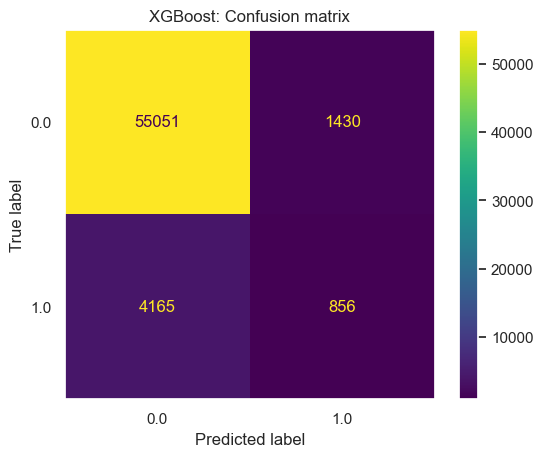

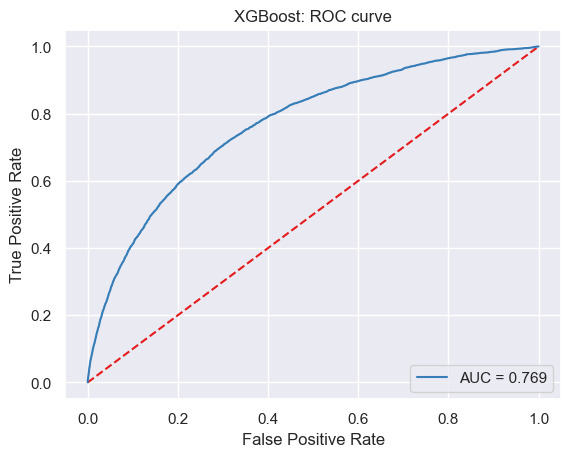

,precision,recall,f1-score,support
0.0,0.929664,0.974682,0.951641,56481.000000
1.0,0.374453,0.170484,0.234296,5021.000000
accuracy,0.909027,0.909027,0.909027,0.909027
macro avg,0.652059,0.572583,0.592968,61502.000000
weighted avg,0.884337,0.909027,0.893077,61502.000000


Business score = 0.7004650255276251
CPU times: user 16min 24s, sys: 2min 7s, total: 18min 31s
Wall time: 3min 18s


In [24]:
%%time

# Create XGBoost classifier
xgbc = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbc_name = 'XGBoost'

# Train model
xgbc.fit(x_res, y_res)

# Compute results
xgbc_business_score, xgbc_auc, xgbc_report = compute_classification_results(xgbc, xgbc_name, x_test, y_test)

# Save logs
xgbc_params = xgbc.get_params()
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# LightGBM

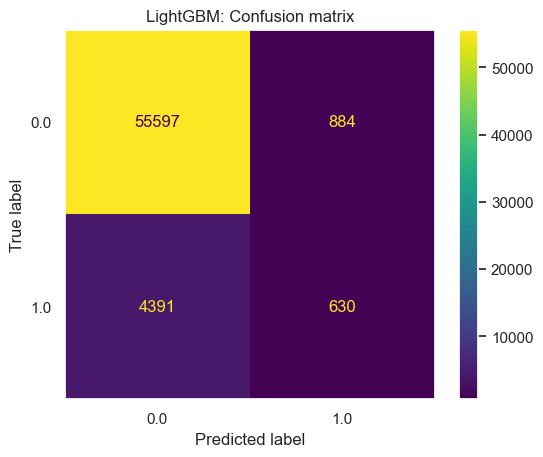

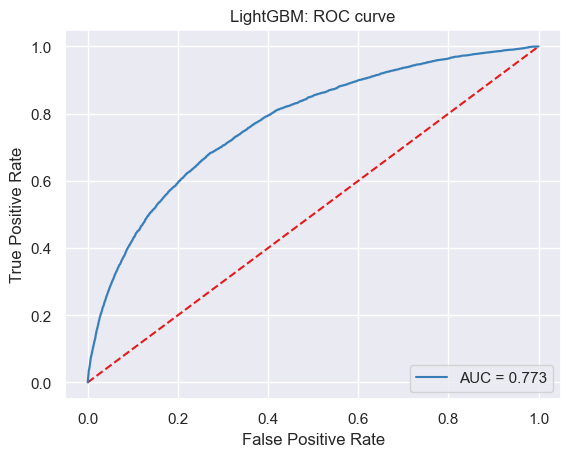

,precision,recall,f1-score,support
0.0,0.926802,0.984349,0.954709,56481.00000
1.0,0.416116,0.125473,0.192808,5021.00000
accuracy,0.914230,0.914230,0.914230,0.91423
macro avg,0.671459,0.554911,0.573758,61502.00000
weighted avg,0.885110,0.914230,0.892508,61502.00000


Business score = 0.7283340379174661
CPU times: user 1min 14s, sys: 2.56 s, total: 1min 17s
Wall time: 38.3 s


In [25]:
%%time

# Create LightGBM classifier
lgbm = ltb.LGBMClassifier(random_state=RANDOM_STATE)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(x_res, y_res)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report = compute_classification_results(lgbm, lgbm_name, x_test, y_test)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# Comparison

In [44]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM'],
    'Business score': [dc_business_score, lr_business_score, rf_business_score, xgbc_business_score, lgbm_business_score],
    'Accuracy': [dc_report.loc['accuracy', 'precision'],
                 lr_report.loc['accuracy', 'precision'],
                 rf_report.loc['accuracy', 'precision'],
                 xgbc_report.loc['accuracy', 'precision'],
                 lgbm_report.loc['accuracy', 'precision']],
    'Precision': [dc_report.loc['macro avg', 'precision'],
                 lr_report.loc['macro avg', 'precision'],
                 rf_report.loc['macro avg', 'precision'],
                 xgbc_report.loc['macro avg', 'precision'],
                 lgbm_report.loc['macro avg', 'precision']],
    'Recall': [dc_report.loc['macro avg', 'recall'],
               lr_report.loc['macro avg', 'recall'],
               rf_report.loc['macro avg', 'recall'],
               xgbc_report.loc['macro avg', 'recall'],
               lgbm_report.loc['macro avg', 'recall']],
    'F-1 score': [dc_report.loc['macro avg', 'f1-score'],
                  lr_report.loc['macro avg', 'f1-score'],
                  rf_report.loc['macro avg', 'f1-score'],
                  xgbc_report.loc['macro avg', 'f1-score'],
                 lgbm_report.loc['macro avg', 'f1-score']],
    'AUC score': [dc_auc, lr_auc, rf_auc, xgbc_auc, lgbm_auc],
})

display(res_df)

,Model,Business score,Accuracy,Precision,Recall,F-1 score,AUC score
0,Dummy,0.863598,0.500341,0.500695,0.502318,0.394594,0.502318
1,LogisticRegression,0.782153,0.871533,0.530624,0.524769,0.526839,0.564350
2,RandomForest,0.797714,0.917873,0.684371,0.511620,0.503198,0.730646
3,XGBoost,0.700465,0.909027,0.652059,0.572583,0.592968,0.769275
4,LightGBM,0.728334,0.914230,0.671459,0.554911,0.573758,0.772866


**The best model regarding our business score is the XGBoost model.**
<br>I decide to select this model for the project. 

Let's tune its hyperparameters.

# Hyperparametrization

XGBoost tuning

In [ ]:
%%time

# Create XGBoost classifier for tuning
xgbt = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbt_name = 'XGBoost_tuned'

# Possible values of hyperparameters
xgbt_space = {'max_depth':  scope.int(hp.quniform("max_depth", 3, 18, 1)),
              'subsample':  hp.uniform('subsample', 0.5, 1.),
              'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.5),
              'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
              'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
              'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50))}

# define objective function
def xgbt_tuning(params):
    print(params)
    xgbt.set_params(**params)
    score = cross_val_score(xgbt, x_res, y_res, scoring=business_score).mean()
    return {"loss": -score, "status": STATUS_OK, "model":xgbt}

# Initialize trials object
xgbt_trials = Trials()

# Find best model
xgbt_best = fmin(fn=xgbt_tuning, space=xgbt_space, algo=tpe.suggest, max_evals=10, trials=xgbt_trials)
xgbt_best_model = trials_best_model(xgbt_trials)
print(xgbt_best_model)

# Train model
xgbt_best_model.fit(x_res, y_res)

# Compute results
xgbt_business_score, xgbt_auc, xgbt_report = compute_classification_results(xgbt_best_model, xgbt_name, x_test, y_test)

# Save logs
xgbt_params = xgbt.get_params()
log_mlflow(xgbt_best_model, xgbt_name,
           custom_score=xgbt_business_score,
           auc_score=xgbt_auc,
           f1_score=xgbt_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbt_report.loc['accuracy', 'precision'],
           n_estimator=xgbt_params['n_estimators'],
           max_depth=xgbt_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

The tuned model is slightly better than the standard xgboost.

In [ ]:
xgb_score_imp = (xgbc_business_score - xgbt_business_score) / xgbc_business_score
print("The XGBoost model improved the business score by {:.1%}".format(xgb_score_imp))

The XGBoost model improved the business score by -1.8%


The XGBoost tuned model is slightly better than the standard model (1.1%) but took more than one day of computation.

**I decide to keep the standard XGBoost model for this project.**

# Custom threshold

In [50]:
# Get proba predictions from xgbc model to be class 1 : repay failure
xgbc_proba = xgbc.predict_proba(x_test)[:,1]

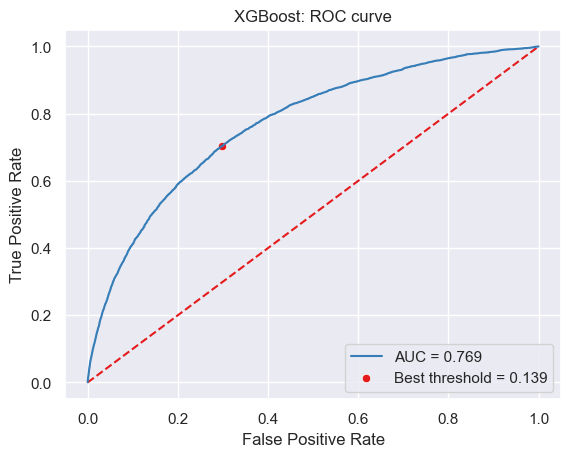

In [52]:
# Draw roc curve
auc_score = compute_roc_curve(y_test, xgbc_proba, model_name='XGBoost', disp_best_th=True)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower.
<br>Here it gives us **0.139.**

Let's try different value of the prediction threshold : 
* 0.5 - Default
* 0.3 - Optimized
* 0.15 - Approximately the thresold given by the ROC curve
* 0.1 - Lower value than the thresold given by the ROC curve

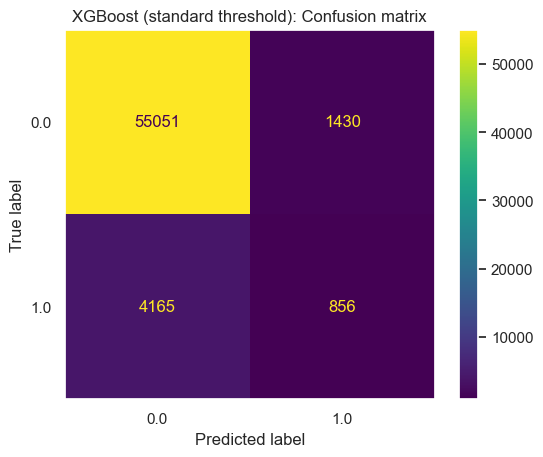

Business score = 0.7004650255276251


,precision,recall,f1-score,support
0.0,0.929664,0.974682,0.951641,56481.000000
1.0,0.374453,0.170484,0.234296,5021.000000
accuracy,0.909027,0.909027,0.909027,0.909027
macro avg,0.652059,0.572583,0.592968,61502.000000
weighted avg,0.884337,0.909027,0.893077,61502.000000


In [54]:
# Compute confusion matrix with standard threshold (0.5)
xgbc_pred_std = xgbc_proba >= 0.5
display_confusion_matrix(y_test, xgbc_pred_std, model_name='XGBoost (standard threshold)')
business_score = business_loss_func(y_test, xgbc_pred_std)
print("Business score =", business_score)
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_std, output_dict=True)).transpose()
display(clf_report)


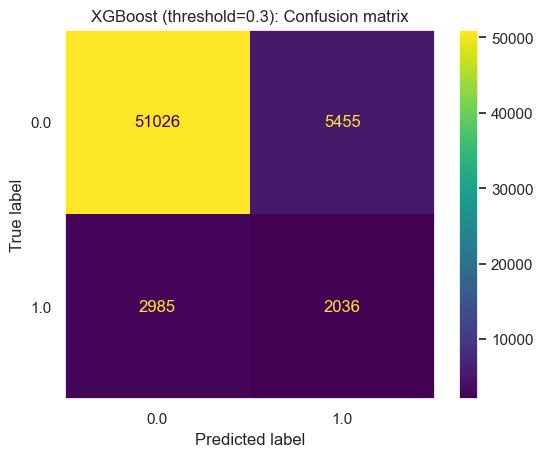

Business score = 0.5740463724756919


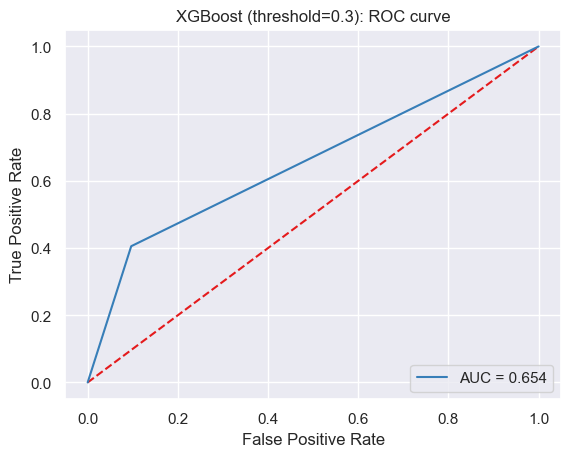

,precision,recall,f1-score,support
0.0,0.944733,0.903419,0.923614,56481.000000
1.0,0.271793,0.405497,0.325448,5021.000000
accuracy,0.862769,0.862769,0.862769,0.862769
macro avg,0.608263,0.654458,0.624531,61502.000000
weighted avg,0.889795,0.862769,0.874780,61502.000000


In [56]:
# Compute confusion matrix with custom threshold (0.3)
xgbc_pred_cstm = xgbc_proba >= 0.3
display_confusion_matrix(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.3)')
business_score = business_loss_func(y_test, xgbc_pred_cstm)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.3)')
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_cstm, output_dict=True)).transpose()
display(clf_report)

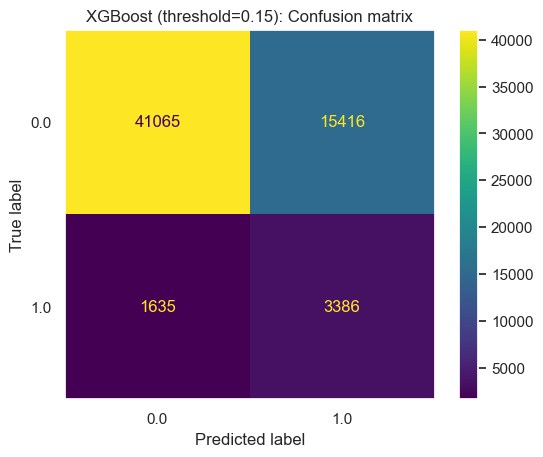

Business score = 0.5165035283405418


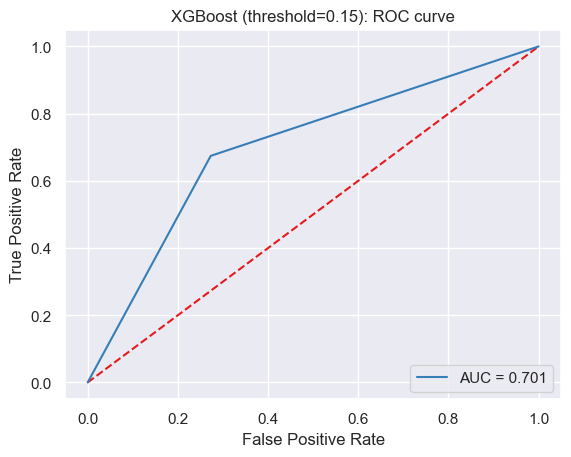

,precision,recall,f1-score,support
0.0,0.961710,0.727059,0.828082,56481.000000
1.0,0.180087,0.674368,0.284263,5021.000000
accuracy,0.722757,0.722757,0.722757,0.722757
macro avg,0.570898,0.700713,0.556173,61502.000000
weighted avg,0.897898,0.722757,0.783685,61502.000000


In [55]:
# Compute confusion matrix with custom threshold (0.15)
xgbc_pred_cstm = xgbc_proba >= 0.15
display_confusion_matrix(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.15)')
business_score = business_loss_func(y_test, xgbc_pred_cstm)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.15)')
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_cstm, output_dict=True)).transpose()
display(clf_report)

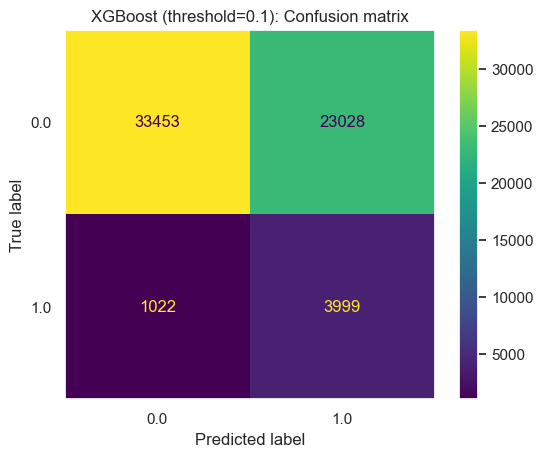

Business score = 0.5406003056811161


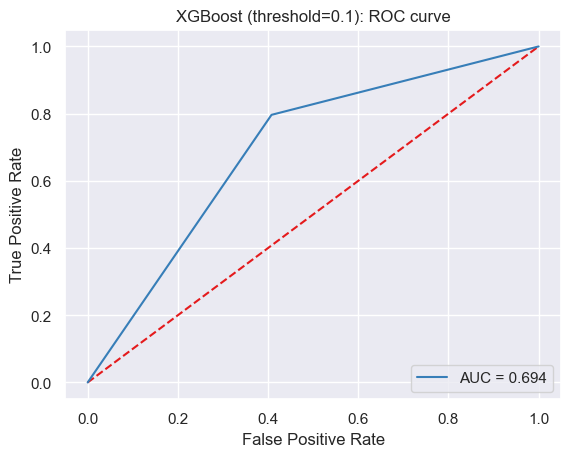

,precision,recall,f1-score,support
0.0,0.970355,0.592288,0.735586,56481.000000
1.0,0.147963,0.796455,0.249563,5021.000000
accuracy,0.608956,0.608956,0.608956,0.608956
macro avg,0.559159,0.694371,0.492575,61502.000000
weighted avg,0.903216,0.608956,0.695908,61502.000000


In [59]:
# Compute confusion matrix with custom threshold (0.1)
xgbc_pred_cstm = xgbc_proba >= 0.1
display_confusion_matrix(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.1)')
business_score = business_loss_func(y_test, xgbc_pred_cstm)
print("Business score =", business_score)
auc_score = compute_roc_curve(y_test, xgbc_pred_cstm, model_name='XGBoost (threshold=0.1)')
clf_report = pd.DataFrame(classification_report(y_test, xgbc_pred_cstm, output_dict=True)).transpose()
display(clf_report)

# Explainer

## LIME

In [32]:
# # Create lime explainer
lime_explainer = lime_tabular.LimeTabularExplainer(x_res, mode="classification",
                                                   class_names=['REPAY SUCCESS', 'REPAY FAILURE'],
                                                   feature_names=features_names)

In [33]:
idx = 1001

print("Prediction : ", xgbc.predict(x_test)[idx])
print("Actual :     ", y_test[idx])

explanation = lime_explainer.explain_instance(x_test[idx], xgbc.predict_proba)

explanation.show_in_notebook()
explanation.as_list()

Prediction :  0
Actual :      1.0


[('NAME_EDUCATION_TYPE_Lower secondary > 0.00', -0.007126711252174709),
 ('NAME_HOUSING_TYPE_Municipal apartment > 0.00', -0.0029982637988609923),
 ('BURO_AMT_CREDIT_MAX_OVERDUE_MEAN > 5242.49', -0.001469394489776522),
 ('OCCUPATION_TYPE_Realty agents <= 0.00', -0.000787595825210203),
 ('ORGANIZATION_TYPE_Legal Services <= 0.00', 0.0007063302502493287),
 ('FLAG_DOCUMENT_17 <= 0.00', -0.000690768254480689),
 ('ORGANIZATION_TYPE_Advertising <= 0.00', -0.0003190151453284096),
 ('ORGANIZATION_TYPE_Emergency <= 0.00', -0.0002882366150520863),
 ('ORGANIZATION_TYPE_Transport: type 1 <= 0.00', -0.00021854911587117928),
 ('ORGANIZATION_TYPE_Trade: type 4 <= 0.00', 3.089115593915081e-06)]

## SHAP

In [34]:
# Compute shap values
shap_explainer = shap.TreeExplainer(xgbc, feature_names=features_names)
shap_values = shap_explainer(x_res)
test_shap_values = shap_explainer(x_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [35]:
# Explain instance
shap.initjs()
shap.plots.force(test_shap_values[idx])

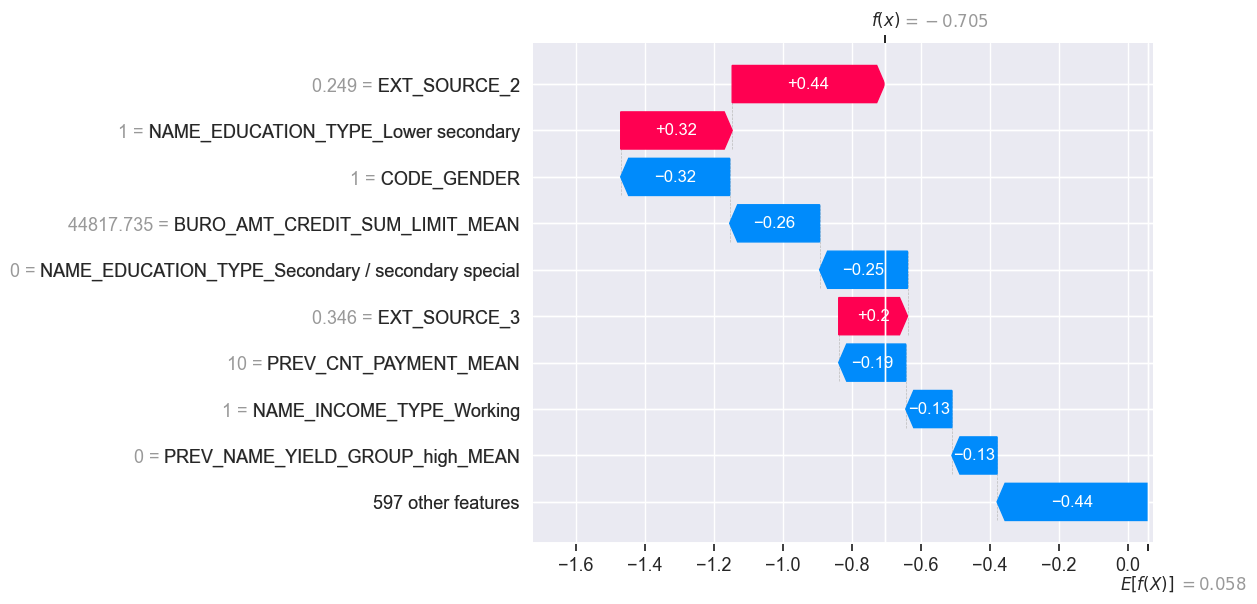

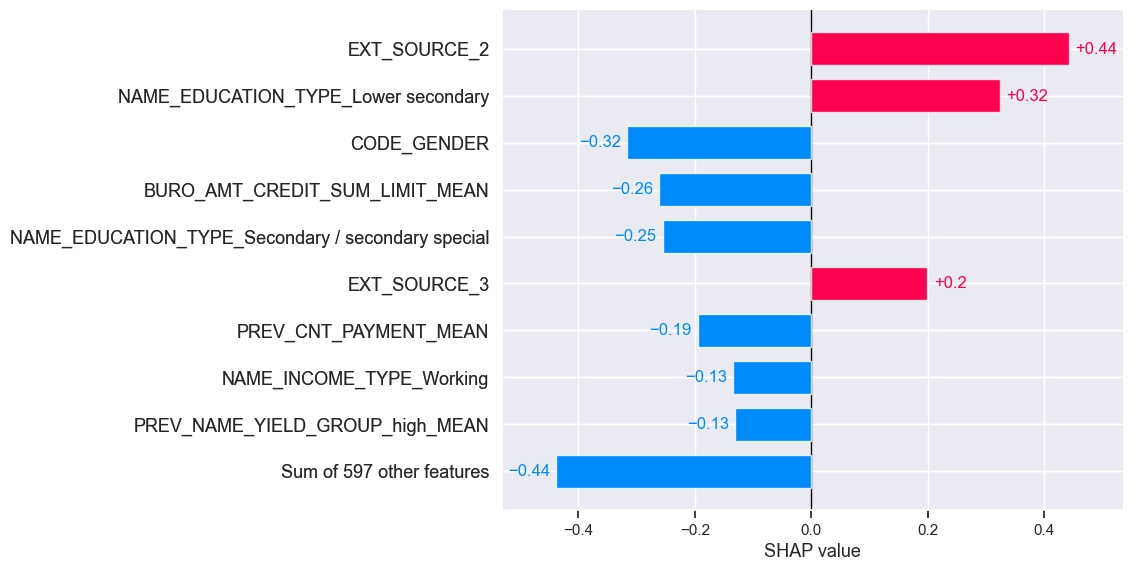

In [36]:
shap.plots.waterfall(test_shap_values[idx])
shap.plots.bar(test_shap_values[idx])

The LIME explainer seems to have troubles to explain instances.
<br>I decide to keep the SHAP explainer for this project.

# Feature importances

I use the XGBoost feature_importances_ built in method to get the feature importance of the trained model.

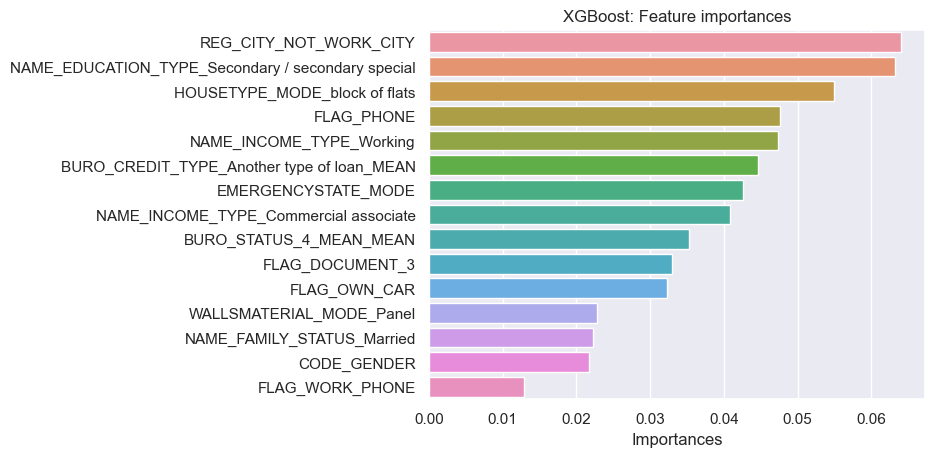

In [57]:
# Get feature importance 15 first values
values = sorted(zip(xgbc.feature_importances_, features_names), reverse=True)[:15]

# Draw feature importances chart
plt.title("XGBoost: Feature importances")
sns.barplot(x=np.array(list(zip(*values))[0]), y=np.array(list(zip(*values))[1]))
plt.xlabel('Importances')
plt.show()

I also display the feature importances based on the SHAP values (only on the test set!)

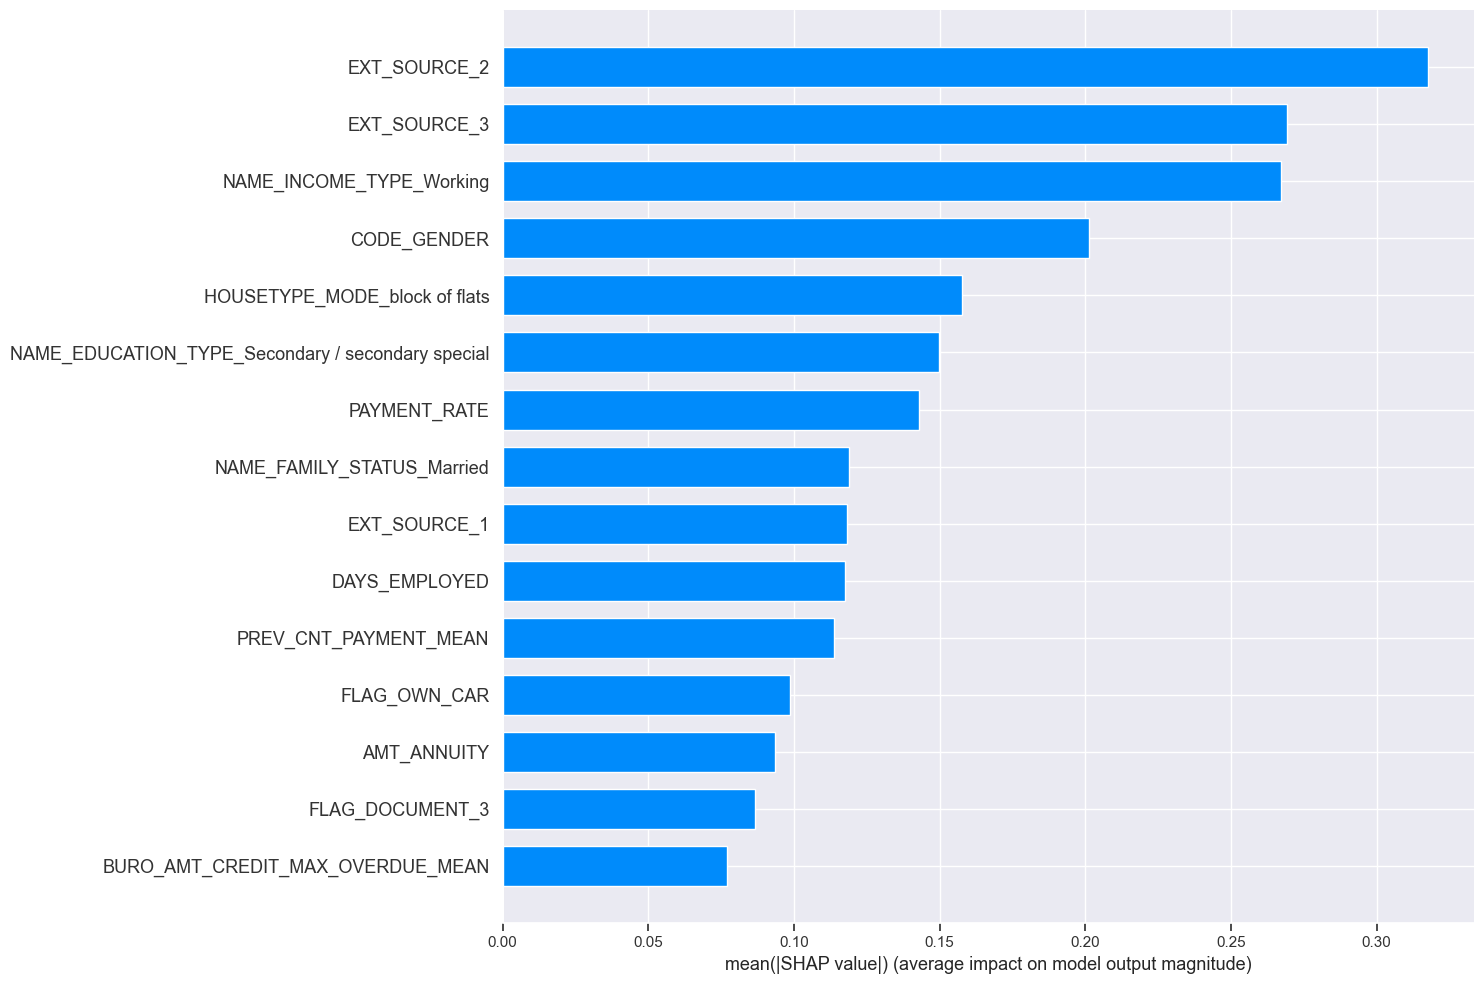

In [38]:
# Display feature importance
shap.summary_plot(test_shap_values, max_display=15,
                  class_names=['Repay success', 'Repay failure'],
                  plot_type='bar', plot_size=(15,10),
                  title='Feature importances (SHAP values)')

# Export

I export the XGBoost default model (selected as best model)

In [39]:
# Best model
best_model = xgbc

# Serialize model
filename = 'models/xgboost_classifier.pckl'
pickle.dump(best_model, open(filename, 'wb'))

I export the SHAP explainer based on the XGBoost default model.

In [40]:
# Serialize explainer
filename = 'models/xgboost_shap_explainer.pckl'
pickle.dump(shap_explainer, open(filename, 'wb'))

# Serialize explainer
# with open('models/xgboost_shap_explainer.pckl', 'wb') as f:
#     dill.dump(shap_explainer, f)